# DocLLM v0.4.x - KV Extraction Flow

- Task https://app.clickup.com/t/86cz2fp9t

In [66]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import copy
from typing import List, Dict
import pandas as pd
from loguru import logger
import os 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/media/veracrypt1/GAC.json" #path to your GCP credentials
from utils import get_img_and_df, plot_bboxes

In [68]:
from docllm import hello
hello()

'Hello from docllm-0.6.3!'

## Get img and df

In [69]:
filename = "data/invoice_10pgs.pdf"
filename

'data/invoice_10pgs.pdf'

In [70]:
# ocr_mode = None # "ocr"
ocr_mode = "ocr"
# is_image = True
is_image = False
# ocr_reader = "aws"
ocr_reader = "google"
df_list, imgs, r_angles = get_img_and_df(file_path=filename, ocr_reader=ocr_reader, mode=ocr_mode, is_image=is_image)

len(df_list), len(imgs)

2025-05-27 15:44:21.546 | INFO     | utils:get_img_and_df:55 - Doing OCR to read the file
2025-05-27 15:44:21.563 | INFO     | docsumo_image_util.parse.ocr.google:read_everything:345 - Reading data using Google OCR
2025-05-27 15:44:21.564 | INFO     | docsumo_image_util.parse.ocr.google:read_raw:116 - Using Google OCR provider
2025-05-27 15:44:23.075 | INFO     | docsumo_image_util.parse.ocr.google:read_everything:348 - Parsing responses with four points
2025-05-27 15:44:23.189 | INFO     | docsumo_image_util.parse.ocr.google:read_everything:356 - 0.0
2025-05-27 15:44:23.190 | INFO     | docsumo_image_util.parse.ocr.google:read_everything:362 - Using 4-point rotation transformation.
2025-05-27 15:44:23.239 | INFO     | docsumo_image_util.parse.ocr.google:read_everything:345 - Reading data using Google OCR
2025-05-27 15:44:23.240 | INFO     | docsumo_image_util.parse.ocr.google:read_raw:116 - Using Google OCR provider
2025-05-27 15:44:24.570 | INFO     | docsumo_image_util.parse.ocr.goo

(10, 10)

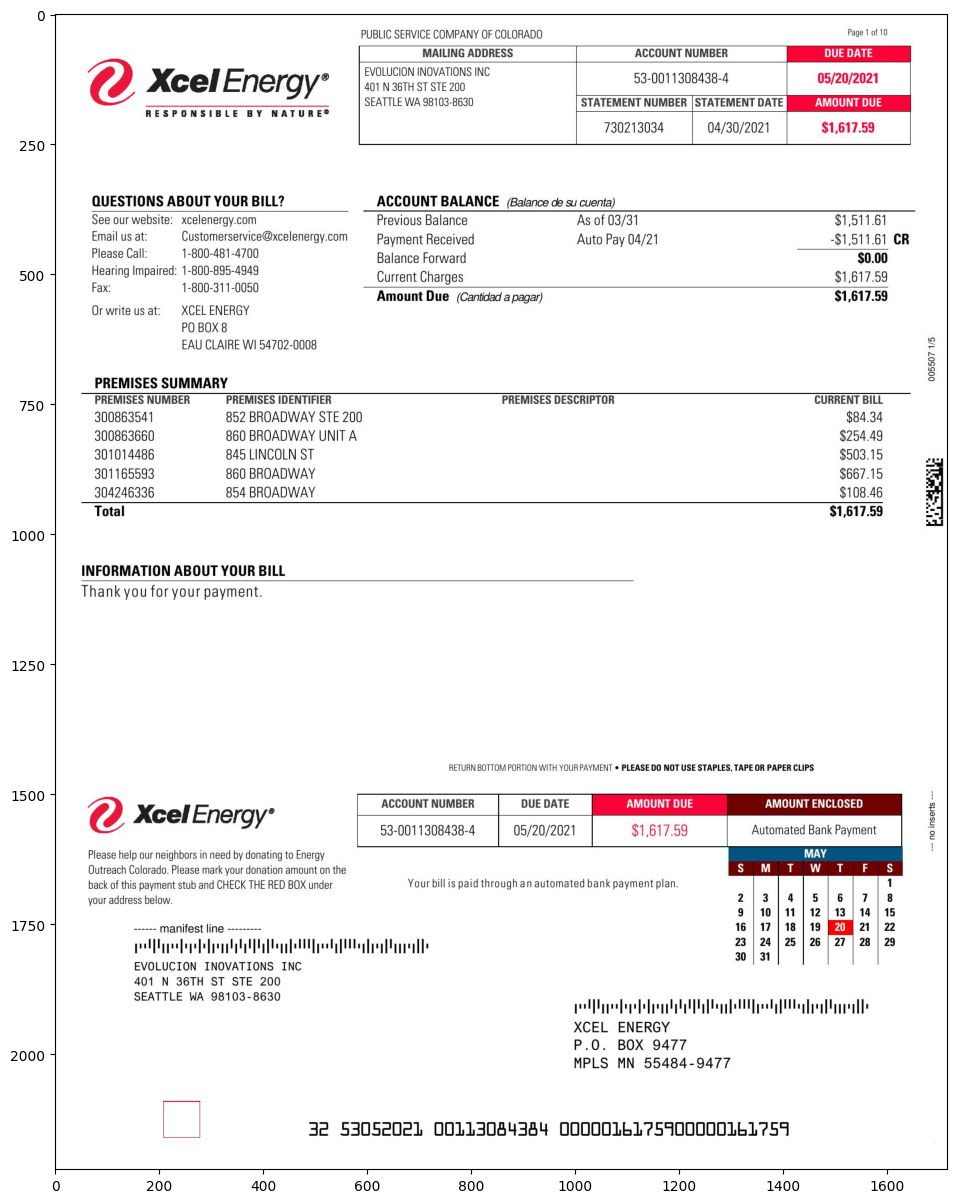

In [71]:
MAIN_IDX = 0
bbxs = [[0, 0, 0, 0]]
plot_bboxes(imgs[MAIN_IDX], bbxs)

In [72]:
df_list[0]

,index_sort,page,block,line,x0,y0,x2,y2,Text,space_type,confidence
0,0,0,0,0,589,30,647,47,PUBLIC,1,0.992612
1,1,0,0,0,652,30,723,47,SERVICE,1,0.990878
2,2,0,0,0,727,30,815,47,COMPANY,1,0.982113
3,3,0,0,0,821,30,842,47,OF,1,0.987860
4,4,0,0,0,845,30,937,47,COLORADO,5,0.991781
...,...,...,...,...,...,...,...,...,...,...,...
296,320,0,93,0,1676,1517,1690,1565,inserts,1,0.963855
297,321,0,93,0,1677,1509,1689,1513,-,5,0.579997
298,322,0,94,0,1678,649,1691,707,005507,1,0.986146
299,323,0,94,0,1678,620,1691,644,1/5,5,0.977405


In [73]:
df_list[3]

,index_sort,page,block,line,x0,y0,x2,y2,Text,space_type,confidence
0,0,0,0,0,162,91,318,159,Xcel,1,0.877467
1,1,0,0,0,321,94,520,164,Energy®,5,0.919620
2,2,0,1,0,706,68,787,84,MAILING,1,0.992511
3,3,0,1,0,793,68,880,84,ADDRESS,3,0.993800
4,4,0,1,1,596,103,689,119,EVOLUCION,1,0.991758
...,...,...,...,...,...,...,...,...,...,...,...
328,373,0,139,0,199,2115,234,2139,Adj,5,0.981974
329,374,0,140,0,527,2116,539,2135,0,1,0.577236
330,375,0,140,0,549,2116,621,2135,therms,5,0.978112
331,377,0,141,0,744,2116,852,2136,$0.047610,5,0.989500


**Scaling the height of each page in DF**

Reason: Currently, each page is independent and their y0 starts from 0

In [74]:
def scale_dataframe(
    df_list: List[pd.DataFrame],
    page_scalars: List[Dict],
) -> List[pd.DataFrame]:
    """
    Scales the list of dataframes from all the pages into a single dataframe.

    Args:
        df_list (List[pd.DataFrame]): A list of DataFrame objects for each page.
        page_scalars (List[Dict]): A list of page scalars for each page.
            Eg: [{"height": 1491, "width": 2258, "angle": 0.0}, {"height": 2211, "width": 1709, "angle": 0.0}]

    Returns:
        List[pd.DataFrame]: Height scaled dataframe.
    """
    height_from_top = 0
    df_list_new = []

    for page, (df, page_scalar) in enumerate(zip(df_list, page_scalars)):
        df = copy.deepcopy(df)

        # making sure that ocr df is not scaled already
        if df.y0.median() < height_from_top:
            df["y0"] = df["y0"] + height_from_top
            df["y2"] = df["y2"] + height_from_top

        df["page"] = page
        df_list_new.append(df)
        height_from_top += page_scalar.get("height", 0)

    return df_list_new

In [75]:
# build page scalars
page_scalars = [
    {"height": img.shape[0], "width": img.shape[1], "angle": angle}
    for img, angle in zip(imgs, r_angles)
]

# scale the df
df_list = scale_dataframe(df_list, page_scalars)

In [110]:
df_list[0]

,index_sort,page,block,line,x0,y0,x2,y2,Text,space_type,confidence
0,0,0,0,0,589,30,647,47,PUBLIC,1,0.992612
1,1,0,0,0,652,30,723,47,SERVICE,1,0.990878
2,2,0,0,0,727,30,815,47,COMPANY,1,0.982113
3,3,0,0,0,821,30,842,47,OF,1,0.987860
4,4,0,0,0,845,30,937,47,COLORADO,5,0.991781
...,...,...,...,...,...,...,...,...,...,...,...
296,320,0,93,0,1676,1517,1690,1565,inserts,1,0.963855
297,321,0,93,0,1677,1509,1689,1513,-,5,0.579997
298,322,0,94,0,1678,649,1691,707,005507,1,0.986146
299,323,0,94,0,1678,620,1691,644,1/5,5,0.977405


## Parse the df using Input Parsing Method 

- Detail on input parsing : https://app.clickup.com/3304041/docs/34uk9-44996/34uk9-83616

In [111]:
from docllm.parser import InputParsingMethod, get_input_parsing_method

In [112]:
parsing_func = get_input_parsing_method(InputParsingMethod.LayoutConserved)
text = parsing_func(df_list[0])
print(text)

                                                                                                                      PUBLIC      SERVICE        COMPANY            OF   COLORADO                                                                                                                                Page  1  of 10
                                                                                                                                             MAILING          ADDRESS                                                          ACCOUNT            NUMBER                                                DUE      DATE
                                 Xcel                           Energy®                                                EVOLUCION           INOVATIONS            INC
                                                                                                                                                                                                             

## New implementation of optimized layout parser using different config methods


In [113]:
from docllm.parser import get_layout_config_creator
from docllm.parser import get_input_parsing_method
from docllm.parser import LayoutConfigMethod

### creating the debug config

In [114]:
debug_config_creator = get_layout_config_creator(LayoutConfigMethod.CreateDebugConfig)

In [115]:
debug_config = debug_config_creator()

In [116]:
# Get the parsing function
parse_fn = get_input_parsing_method(InputParsingMethod.LayoutAwareText)

In [117]:
# Parse the DataFrame with the custom config
result_text = parse_fn(df_list[0], config=debug_config)


Page width: 1651.00
Average char width: 11.29
Detected column positions: ['65.5', '76.1', '104.0', '129.0', '151.5', '174.5', '200.2', '223.5', '241.5', '264.0', '287.3', '310.1', '330.8', '372.4', '397.0', '442.0', '507.7', '555.3', '595.0', '621.7', '697.3', '715.6', '760.8', '872.6', '963.2', '993.0', '1006.6', '1059.3', '1080.0', '1099.2', '1123.0', '1150.0', '1308.2', '1352.4', '1364.3', '1402.5', '1455.0', '1483.2', '1502.6', '1522.7', '1548.8', '1593.2', '1677.2']
Total character width: 156


In [118]:
print(result_text)

<line_no>0</line_no>                                                PUBLIC SERVICE COMPANY OF COLORADO                                              Page of 10

<line_no>1</line_no>                                                         MAILING ADDRESS                    ACCOUNT   NUMBER                DUE DATE
<line_no>2</line_no>                                                EVOLUCION INOVATIONS INC
<line_no>3</line_no>                                                                                            53-0011308438-4                 05/20/2021
<line_no>4</line_no>        Xcel         Energy®
<line_no>5</line_no>                                                401 36TH ST STE 200
<line_no>6</line_no>                                                SEATTLE  WA 98103-8630             STATEMENT   NUMBER   STATEMENT  DATE     AMOUNT  DUE
<line_no>7</line_no>        RESPONSIBLE         BY NATURE®
<line_no>8</line_no>                                                                   

## creating the precise alignment config

In [119]:
precise_config_creator = get_layout_config_creator(LayoutConfigMethod.CreatePreciseAlignmentConfig)

In [120]:
precise_config = precise_config_creator()

In [121]:
# Get the parsing function
parse_fn = get_input_parsing_method(InputParsingMethod.LayoutAwareText)

In [140]:
# Parse the DataFrame with the custom config
result_text = parse_fn(df_list[5], config=precise_config)


In [141]:
print(result_text)

<line_no>0</line_no>                                                                                                                             Page of 10

<line_no>1</line_no>                                                      MAILING ADDRESS                    ACCOUNT NUMBER                  DUE DATE

<line_no>2</line_no>                                               EVOLUCION INOVATIONS INC
<line_no>3</line_no>                                                                                         53-0011308438-4                 05/20/2021
<line_no>4</line_no>อ         Xcel        Energy®
<line_no>5</line_no>                                               401 36TH ST STE 200
<line_no>6</line_no>                                               SEATTLE WA 98103-8630            STATEMENT  NUMBER  STATEMENT DATE        AMOUNT DUE

<line_no>7</line_no>                                                                                     730213034       04/30/2021          $1,617.59

<line_

## creating loose alignment config

In [124]:
loose_config=get_layout_config_creator(LayoutConfigMethod.CreateLooseAlignmentConfig)

In [125]:
loose_config = loose_config()

In [126]:
parse_fn = get_input_parsing_method(InputParsingMethod.LayoutAwareText)

In [127]:
result_text=parse_fn(df_list[1], config=loose_config)

In [128]:
print(result_text)

<line_no>0</line_no>                                                                                                                     Page of 10

<line_no>1</line_no>                                                  MAILING ADDRESS                   ACCOUNT NUMBER                DUE DATE
<line_no>2</line_no>                                           EVOLUCION INOVATIONS INC
<line_no>3</line_no>                                                                                    53-0011308438-4               05/20/2021
<line_no>4</line_no> ②Xcel             Energy®
<line_no>5</line_no>                                           401 36TH STE 200
<line_no>6</line_no>                                           SEATTLE WA 98103-8630            STATEMENT NUMBER  STATEMENT DATE      AMOUNT DUE

<line_no>7</line_no>                                                                                730213034       04/30/2021        $1,617.59

<line_no>8</line_no>                   Last Year         

## creating custom config

In [142]:
custom_config_creator=get_layout_config_creator(LayoutConfigMethod.CreateCustomConfig)

In [147]:
# Create config by passing kwargs (using Python's partial or a lambda)
custom_config = custom_config_creator(
    char_width_method='median',
    column_alignment_threshold=0.1,
    min_word_spacing=2,
    preserve_proportional_spacing=True,
    debug_output=True
)

In [148]:
parse_fn = get_input_parsing_method(InputParsingMethod.LayoutAwareText)

In [149]:
result_text = parse_fn(df_list[1], config=custom_config)

Page width: 1581.00
Average char width: 12.18
Detected column positions: ['77.4', '163.0', '296.7', '317.3', '421.3', '511.4', '590.2', '618.4', '634.8', '653.3', '680.8', '701.9', '727.2', '754.0', '779.5', '801.2', '830.8', '846.5', '876.2', '994.8', '1023.5', '1045.8', '1062.8', '1090.9', '1116.8', '1138.6', '1165.5', '1185.4', '1214.8', '1235.6', '1260.4', '1286.7', '1309.0', '1337.8', '1354.3', '1385.5', '1427.3', '1460.2', '1477.0', '1497.4', '1529.8', '1546.5', '1576.5']
Total character width: 139


In [150]:
print(result_text)

<line_no>0</line_no>                                                                                                                     Page 2 of 10

<line_no>1</line_no>                                                  MAILING ADDRESS                   ACCOUNT NUMBER                DUE DATE
<line_no>2</line_no>                                           EVOLUCION INOVATIONS INC
<line_no>3</line_no>                                                                                    53-0011308438-4               05/20/2021
<line_no>4</line_no> ②Xcel             Energy®
<line_no>5</line_no>                                           401 N 36TH ST STE 200
<line_no>6</line_no>                                           SEATTLE WA 98103-8630            STATEMENT NUMBER  STATEMENT DATE      AMOUNT DUE

<line_no>7</line_no>                                                                                730213034       04/30/2021        $1,617.59

<line_no>8</line_no>                   Last Year  